In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

In [3]:
data = pd.read_table("3B.tsv")
data.head()

,url,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),sell_beverages,sell_chinese_food,sell_thai_food,sell_indian_food,sell_mediterranean_food,sell_fast_food,sell_desserts
0,https://www.zomato.com/bangalore/faasos-1-vasa...,Faasos,Yes,No,3.8,101,Vasanth Nagar,Delivery,"North Indian, Biryani, Fast Food",500,Delivery,no,no,no,yes,no,yes,no
1,https://www.zomato.com/bangalore/khanapur-expr...,Khanapur Express,No,No,NaN,0,JP Nagar,Quick Bites,"North Indian, Rajasthani",500,Delivery,no,no,no,yes,no,no,no
2,https://www.zomato.com/bangalore/russh-gastrop...,Russh Gastropub,No,No,4.2,1279,Church Street,Pub,"Continental, Italian, Burger","1,100",Drinks & nightlife,no,no,no,no,no,yes,no
3,https://www.zomato.com/bangalore/bangalir-rann...,Bangalir Rannaghar,No,No,2.9,58,Bannerghatta Road,Quick Bites,"Bengali, North Indian, Chinese",250,Dine-out,no,yes,no,yes,no,no,no
4,https://www.zomato.com/bangalore/natural-mumba...,Natural Mumbai Kulfi,Yes,No,3.5,8,BTM,Dessert Parlor,Ice Cream,130,Delivery,no,no,no,no,no,no,yes


EDA

In [4]:
print(data.isnull().sum()) #terdapat byk null value ya

url                               0
name                              0
online_order                      0
book_table                        0
rate                           2264
votes                             0
location                          8
rest_type                        69
cuisines                         12
approx_cost(for two people)      92
listed_in(type)                   0
sell_beverages                   12
sell_chinese_food                12
sell_thai_food                   12
sell_indian_food                 12
sell_mediterranean_food          12
sell_fast_food                   12
sell_desserts                    12
dtype: int64


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          15000 non-null  object
 1   name                         15000 non-null  object
 2   online_order                 15000 non-null  object
 3   book_table                   15000 non-null  object
 4   rate                         12736 non-null  object
 5   votes                        15000 non-null  int64 
 6   location                     14992 non-null  object
 7   rest_type                    14931 non-null  object
 8   cuisines                     14988 non-null  object
 9   approx_cost(for two people)  14908 non-null  object
 10  listed_in(type)              15000 non-null  object
 11  sell_beverages               14988 non-null  object
 12  sell_chinese_food            14988 non-null  object
 13  sell_thai_food               14

In [6]:
print(data.head(10)) 

                                                 url                  name  \
0  https://www.zomato.com/bangalore/faasos-1-vasa...                Faasos   
1  https://www.zomato.com/bangalore/khanapur-expr...      Khanapur Express   
2  https://www.zomato.com/bangalore/russh-gastrop...       Russh Gastropub   
3  https://www.zomato.com/bangalore/bangalir-rann...    Bangalir Rannaghar   
4  https://www.zomato.com/bangalore/natural-mumba...  Natural Mumbai Kulfi   
5  https://www.zomato.com/bangalore/chai-resto-1-...            Chai Resto   
6  https://www.zomato.com/bangalore/mimansa-foxtr...     Mimansa @ Foxtrot   
7  https://www.zomato.com/bangalore/ciclo-cafe-in...            Ciclo Cafe   
8  https://www.zomato.com/bangalore/the-kebab-hou...       The Kebab House   
9  https://www.zomato.com/bangalore/sri-krishna-k...   Sri Krishna Kitchen   

  online_order book_table  rate  votes               location  \
0          Yes         No   3.8    101          Vasanth Nagar   
1          

In [29]:
#i dropped this bcs it is too irreparable -> too many missing values && not really significant
data.dropna(subset=['rest_type', 'sell_beverages', 'approx_cost(for two people)'], axis=0)
data.drop('url', axis = 1, inplace = True)

In [26]:
#replace specific non-numeric values in the 'rate' column with NaN
data['rate'] = data['rate'].replace(["NEW", "-", "X"], np.nan)
data['rate'] = data['rate'].astype("float64")

#replace remaining NaN values in 'rate' with the mean of the column
data['rate'] = data['rate'].fillna(round(np.mean(data['rate'])))

In [46]:
#remove commas and convert the data type
data['approx_cost(for two people)'] = data['approx_cost(for two people)'].str.replace(',', '', regex=False)
data['approx_cost(for two people)'] = data['approx_cost(for two people)'].astype("float64")
data['cuisines'] = data['cuisines'].str.replace(',', '', regex=False)

AttributeError: Can only use .str accessor with string values!

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14844 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         14844 non-null  object 
 1   online_order                 14844 non-null  object 
 2   book_table                   14844 non-null  object 
 3   rate                         14844 non-null  float64
 4   votes                        14844 non-null  int64  
 5   location                     14844 non-null  object 
 6   rest_type                    14844 non-null  object 
 7   cuisines                     14844 non-null  object 
 8   approx_cost(for two people)  14844 non-null  float64
 9   listed_in(type)              14844 non-null  object 
 10  sell_beverages               14844 non-null  object 
 11  sell_chinese_food            14844 non-null  object 
 12  sell_thai_food               14844 non-null  object 
 13  sell_indian_food     

In [31]:
data.head(10)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),sell_beverages,sell_chinese_food,sell_thai_food,sell_indian_food,sell_mediterranean_food,sell_fast_food,sell_desserts
0,Faasos,Yes,No,3.8,101,Vasanth Nagar,Delivery,North Indian Biryani Fast Food,500.0,Delivery,no,no,no,yes,no,yes,no
1,Khanapur Express,No,No,4.0,0,JP Nagar,Quick Bites,North Indian Rajasthani,500.0,Delivery,no,no,no,yes,no,no,no
2,Russh Gastropub,No,No,4.2,1279,Church Street,Pub,Continental Italian Burger,1100.0,Drinks & nightlife,no,no,no,no,no,yes,no
3,Bangalir Rannaghar,No,No,2.9,58,Bannerghatta Road,Quick Bites,Bengali North Indian Chinese,250.0,Dine-out,no,yes,no,yes,no,no,no
4,Natural Mumbai Kulfi,Yes,No,3.5,8,BTM,Dessert Parlor,Ice Cream,130.0,Delivery,no,no,no,no,no,no,yes
5,Chai Resto,No,No,3.5,7,Bellandur,Quick Bites,Fast Food Tea,200.0,Cafes,yes,no,no,no,no,yes,no
6,Mimansa @ Foxtrot,Yes,Yes,4.4,190,Koramangala 3rd Block,Cafe,Cafe,1000.0,Delivery,yes,no,no,no,no,no,no
7,Ciclo Cafe,Yes,No,4.3,1273,Indiranagar,"Cafe, Casual Dining",Cafe Italian American,1000.0,Delivery,yes,no,no,no,no,no,no
8,The Kebab House,Yes,No,4.2,51,Bellandur,Quick Bites,Kebab Biryani,250.0,Delivery,no,no,no,yes,no,no,no
9,Sri Krishna Kitchen,Yes,No,3.6,22,Bellandur,Quick Bites,North Indian Chinese,350.0,Delivery,no,yes,no,yes,no,no,no


In [32]:
target_columns = ['cuisines', 'location', 'rest_type']
cuisines_feature = data['cuisines']
location_feature = data['location']
rest_type_feature = data['rest_type']

combined_features = cuisines_feature + " " + location_feature + " " + rest_type_feature
combined_features


0        North Indian Biryani Fast Food Vasanth Nagar D...
1             North Indian Rajasthani JP Nagar Quick Bites
2             Continental Italian Burger Church Street Pub
3        Bengali North Indian Chinese Bannerghatta Road...
4                             Ice Cream BTM Dessert Parlor
                               ...                        
14995                Chinese Biryani Bellandur Quick Bites
14996    Continental Mediterranean European Church Stre...
14997                 North Indian Bellandur Casual Dining
14998    Fast Food Desserts Beverages Indiranagar Quick...
14999          Desserts Beverages Jayanagar Dessert Parlor
Length: 14844, dtype: object

In [35]:
# Create a TF-IDF Vectorizer instance
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_features)

# Reset the dataframe's index for consistency
data = data.reset_index(drop=True)

In [36]:
# Apply Min-Max scaling to numerical columns
scaler = MinMaxScaler()
numerical_columns = ['rate', 'votes', 'approx_cost(for two people)']

# Scale each numerical column using Min-Max normalization
for column in numerical_columns:
    data[column] = scaler.fit_transform(data[[column]])

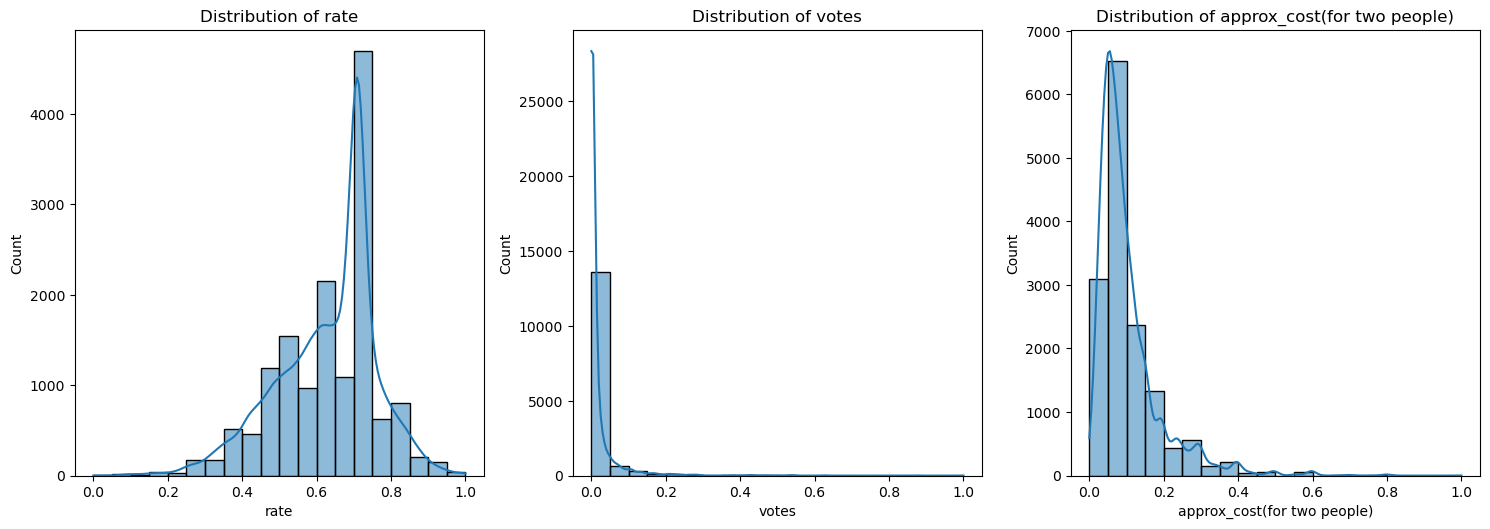

In [83]:
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [37]:
binary_columns = [column for column in data.columns if data[column].nunique() == 2]

#initialize encoders 
encoder = OneHotEncoder(drop=None, sparse_output=False)
label_encoder = LabelEncoder()

#apply Label Encoding to binary columns
for column in binary_columns:
    data[column] = label_encoder.fit_transform(data[column])

#apply OneHotEncoding to 'listed_in(type)' column
encoded_list = encoder.fit_transform(data[['listed_in(type)']])
encoded_columns = encoder.get_feature_names_out(['listed_in(type)'])

#convert the encoded data into a DataFrame
encoded_df = pd.DataFrame(encoded_list, columns=encoded_columns)

In [38]:
#combine the original DataFrame with the one-hot encoded 'listed_in(type)'
df_combined_model = pd.concat([data, encoded_df], axis=1)
df_combined_model

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),...,sell_mediterranean_food,sell_fast_food,sell_desserts,listed_in(type)_Buffet,listed_in(type)_Cafes,listed_in(type)_Delivery,listed_in(type)_Desserts,listed_in(type)_Dine-out,listed_in(type)_Drinks & nightlife,listed_in(type)_Pubs and bars
0,Faasos,1,0,0.645161,0.006060,Vasanth Nagar,Delivery,North Indian Biryani Fast Food,0.092742,Delivery,...,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Khanapur Express,0,0,0.709677,0.000059,JP Nagar,Quick Bites,North Indian Rajasthani,0.092742,Delivery,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Russh Gastropub,0,0,0.774194,0.076041,Church Street,Pub,Continental Italian Burger,0.213710,Drinks & nightlife,...,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Bangalir Rannaghar,0,0,0.354839,0.003505,Bannerghatta Road,Quick Bites,Bengali North Indian Chinese,0.042339,Dine-out,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Natural Mumbai Kulfi,1,0,0.548387,0.000535,BTM,Dessert Parlor,Ice Cream,0.018145,Delivery,...,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14839,Sri Vasavi Restaurant,0,0,0.580645,0.001842,Bellandur,Quick Bites,Chinese Biryani,0.042339,Delivery,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14840,Hoppipola,1,0,0.806452,0.101527,Church Street,Lounge,Continental Mediterranean European,0.254032,Delivery,...,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14841,Ghar Ki Rasoi,1,0,0.612903,0.003030,Bellandur,Casual Dining,North Indian,0.092742,Delivery,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14842,Ice Cubes,0,0,0.387097,0.001010,Indiranagar,Quick Bites,Fast Food Desserts Beverages,0.052419,Dine-out,...,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#i dropped irrelevant columns
df_combined_model = df_combined_model.drop(['name', 'listed_in(type)', 'location', 'rest_type', 'cuisines'], axis=1)

In [53]:
features = tfidf_vectorizer.get_feature_names_out()

#create a DataFrame from the TF-IDF matrix
tfidf_dataframe = pd.DataFrame(tfidf_matrix.toarray(), columns=features)

#concatenate the original model DataFrame and the new TF-IDF DataFrame
combined_features = pd.concat([df_combined_model.reset_index(drop=True), tfidf_dataframe], axis=1)

combined_features.head()

,online_order,book_table,rate,votes,approx_cost(for two people),sell_beverages,sell_chinese_food,sell_thai_food,sell_indian_food,sell_mediterranean_food,...,vasanth,vegan,vietnamese,vijay,west,whitefield,wilson,wraps,yelahanka,yeshwantpur
0,1,0,0.645161,0.006060,0.092742,0,0,0,1,0,...,0.650936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0.709677,0.000059,0.092742,0,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.774194,0.076041,0.213710,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.354839,0.003505,0.042339,0,1,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0.548387,0.000535,0.018145,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
n_components = 100  

svd = TruncatedSVD(n_components=n_components)
features_reduced = svd.fit_transform(combined_features)

features_reduced


array([[ 1.83044551e+00,  4.85238531e-01, -2.33385031e-01, ...,
        -4.69203956e-02, -3.60429433e-02,  2.19909494e-01],
       [ 1.22559354e+00, -7.87651003e-03, -6.37633866e-01, ...,
         7.52061003e-02,  3.02174382e-04, -3.44644145e-02],
       [ 5.37848928e-01,  1.73805198e-01,  5.09098627e-01, ...,
         1.36559567e-02,  3.79859354e-02, -1.03426457e-01],
       ...,
       [ 1.68119366e+00,  2.46330524e-01, -5.79097867e-01, ...,
        -1.83499431e-03, -6.55872271e-03,  2.87995714e-03],
       [ 8.33875607e-01,  1.33183798e-01,  1.51247595e+00, ...,
        -1.05397390e-02,  1.95988402e-02, -6.95966557e-02],
       [ 1.42584793e+00,  1.26197870e+00,  4.22254108e-01, ...,
        -1.23836342e-03, -1.66156621e-03, -3.29687817e-02]])

MODELLING

In [63]:
def get_recommendations_by_name(item_name, data, features_matrix, num_recommendations=5):
    item_idx = data[data['name'] == item_name].index

    #check if the item exists in the dataset
    if item_idx.empty:
        return f"Item with name '{item_name}' not found."
    
    item_idx = item_idx[0]  # Get the actual index value

    #get the feature vector for the specified item
    item_features = features_matrix[item_idx]

    #calculate the cosine similarity between the item and all others
    similarity_scores = cosine_similarity([item_features], features_matrix).flatten()

    #sort the similarity scores in descending order and exclude the first (itself)
    top_indices = np.argsort(similarity_scores)[::-1][1:num_recommendations + 1]

    #retrieve and return the recommended items
    recommendations = data.iloc[top_indices][['name', 'location']]
    return recommendations


EVALUATION

In [64]:
def recommendation(item_name):
    # Get the recommendations by calling the helper function
    rec = get_recommendations_by_name(item_name, data, features_reduced)
    
    # Reset the index and drop the 'index' column
    rec = rec.reset_index(drop=True)
    
    return rec

In [65]:
data.head(10)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),sell_beverages,sell_chinese_food,sell_thai_food,sell_indian_food,sell_mediterranean_food,sell_fast_food,sell_desserts
0,Faasos,1,0,0.645161,0.006060,Vasanth Nagar,Delivery,North Indian Biryani Fast Food,0.092742,Delivery,0,0,0,1,0,1,0
1,Khanapur Express,0,0,0.709677,0.000059,JP Nagar,Quick Bites,North Indian Rajasthani,0.092742,Delivery,0,0,0,1,0,0,0
2,Russh Gastropub,0,0,0.774194,0.076041,Church Street,Pub,Continental Italian Burger,0.213710,Drinks & nightlife,0,0,0,0,0,1,0
3,Bangalir Rannaghar,0,0,0.354839,0.003505,Bannerghatta Road,Quick Bites,Bengali North Indian Chinese,0.042339,Dine-out,0,1,0,1,0,0,0
4,Natural Mumbai Kulfi,1,0,0.548387,0.000535,BTM,Dessert Parlor,Ice Cream,0.018145,Delivery,0,0,0,0,0,0,1
5,Chai Resto,0,0,0.548387,0.000475,Bellandur,Quick Bites,Fast Food Tea,0.032258,Cafes,1,0,0,0,0,1,0
6,Mimansa @ Foxtrot,1,1,0.838710,0.011347,Koramangala 3rd Block,Cafe,Cafe,0.193548,Delivery,1,0,0,0,0,0,0
7,Ciclo Cafe,1,0,0.806452,0.075685,Indiranagar,"Cafe, Casual Dining",Cafe Italian American,0.193548,Delivery,1,0,0,0,0,0,0
8,The Kebab House,1,0,0.774194,0.003089,Bellandur,Quick Bites,Kebab Biryani,0.042339,Delivery,0,0,0,1,0,0,0
9,Sri Krishna Kitchen,1,0,0.580645,0.001366,Bellandur,Quick Bites,North Indian Chinese,0.062500,Delivery,0,1,0,1,0,0,0


In [72]:
recommendation("Chai Resto")

,name,location
0,On the Go Cafeteria,Bellandur
1,On the Go Cafeteria,Bellandur
2,Chaai Resto,Koramangala 6th Block
3,Lassi Bistro,Marathahalli
4,Cafe Qissa,Kalyan Nagar


In [74]:
recommendation("The Kebab House")

,name,location
0,Mani's Dum Biryani,Bellandur
1,Biryani Kitchen,Bellandur
2,Biriyani House,Bellandur
3,Wedding Biryani,HSR
4,Royal Biryani Kitchen,BTM


In [75]:
recommendation("Burger King")

,name,location
0,Maddy's Katti Cafe,Malleshwaram
1,Burger King,Commercial Street
2,Burger King,Kammanahalli
3,Burger Lounge,Koramangala 5th Block
4,Burger Lounge,Koramangala 5th Block
